In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.tsa.statespace as tm_models
from datetime import datetime,time
import warnings
import itertools
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

## 1 - Business Problem

___Forecast the CocaCola prices data set. Prepare a document for each model explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting_

## 2 - Data collection and description

In [ ]:
df = pd.read_excel("/content/CocaCola_Sales_Rawdata.xlsx")
df1 = df.copy()

In [ ]:
df1.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [ ]:
df1.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [ ]:
df1.dtypes

Quarter     object
Sales      float64
dtype: object

In [ ]:
df1.describe().T


,count,mean,std,min,25%,50%,75%,max
Sales,42.0,2994.353308,977.930896,1547.818996,2159.714247,2782.376999,3609.25,5253.0


In [ ]:
temp = df1.Quarter.str.replace(r'(Q\d)_(\d+)', r'19\2-\1')

In [ ]:
df1['quater'] = pd.to_datetime(temp).dt.strftime('%b-%Y')

In [ ]:
df1.head()

,Quarter,Sales,quater
0,Q1_86,1734.827000,Jan-1986
1,Q2_86,2244.960999,Apr-1986
2,Q3_86,2533.804993,Jul-1986
3,Q4_86,2154.962997,Oct-1986
4,Q1_87,1547.818996,Jan-1987


In [ ]:
df1 = df1.drop(['Quarter'], axis=1)

In [ ]:
df1.reset_index(inplace=True)
df1['quater'] = pd.to_datetime(df1['quater'])

In [ ]:
df1 = df1.set_index('quater')

In [ ]:
df1.head()

,index,Sales
quater,,
1986-01-01,0,1734.827000
1986-04-01,1,2244.960999
1986-07-01,2,2533.804993
1986-10-01,3,2154.962997
1987-01-01,4,1547.818996


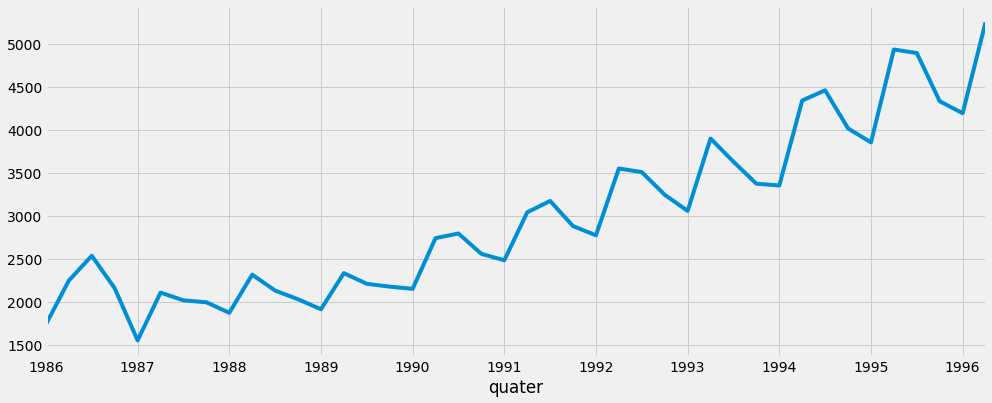

In [ ]:
df1['Sales'].plot(figsize=(15, 6))
plt.show()

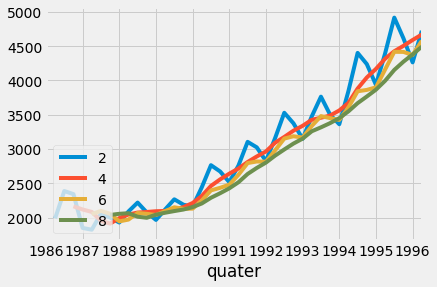

In [ ]:
for i in range(2,10,2):
    df1["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc=3)


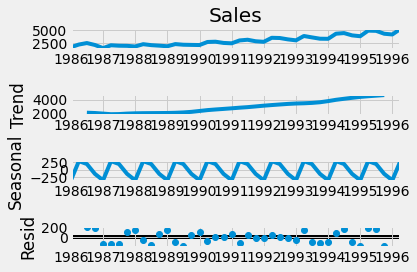

In [ ]:
ts_add = seasonal_decompose(df1.Sales,model="additive")
fig = ts_add.plot()
plt.show()

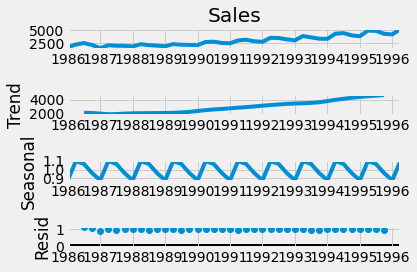

In [ ]:
ts_mul = seasonal_decompose(df1.Sales,model="multiplicative")
fig = ts_mul.plot()
plt.show()

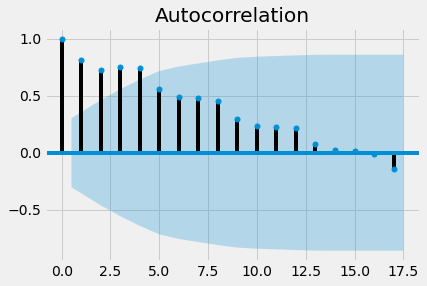

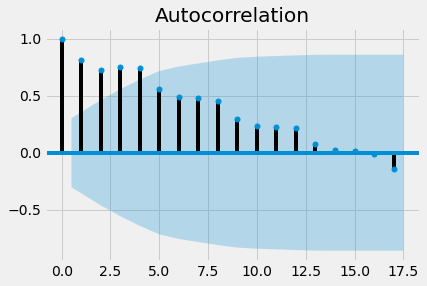

In [ ]:
tsa_plots.plot_acf(df1.Sales)

## 3 - Building Time series forecasting with ARIMA

In [ ]:
X = df1['Sales'].values

In [ ]:
size = int(len(X) * 0.66)

In [ ]:
train, test = X[0:size], X[size:len(X)]
model = ARIMA(train, order=(5,1,0))

In [ ]:
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   26
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -172.036
Method:                       css-mle   S.D. of innovations            163.191
Date:                Thu, 10 Nov 2022   AIC                            358.071
Time:                        05:02:02   BIC                            366.878
Sample:                             1   HQIC                           360.607
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.8444     26.509      1.579      0.114     -10.111      93.800
ar.L1.D.y     -0.1479      0.195     -0.758      0.448      -0.530       0.234
ar.L2.D.y     -0.3127      0.157     -1.996      0.0

This summarizes the coefficient values used as well as the skill of the fit on the on the in-sample observations

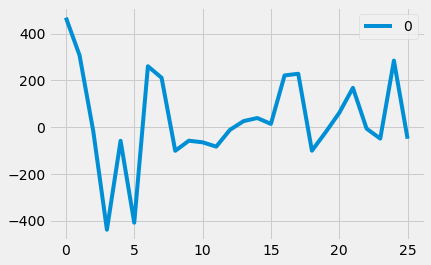

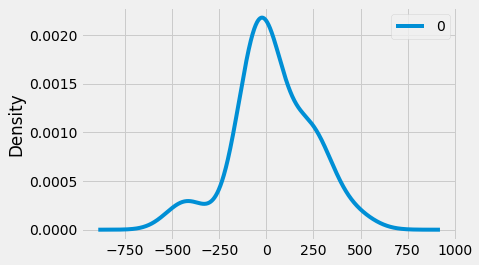

                0
count   26.000000
mean    31.324572
std    202.029942
min   -438.907742
25%    -58.604053
50%     -9.191594
75%    200.235135
max    468.289569


In [ ]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

The plot of the residual errors suggests that there may still be some trend information not captured by the model
The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals)

## 3.1 - Rolling Forecast ARIMA Model

In [ ]:
history = [x for x in train]
predictions = list()

In [ ]:
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=3135.587718, expected=3243.859993
predicted=3188.848659, expected=3056.000000
predicted=3734.223284, expected=3899.000000
predicted=3782.620965, expected=3629.000000
predicted=3355.126081, expected=3373.000000
predicted=3297.217731, expected=3352.000000
predicted=4112.813163, expected=4342.000000
predicted=3961.043275, expected=4461.000000
predicted=4130.785662, expected=4017.000000
predicted=3912.794151, expected=3854.000000
predicted=4687.043943, expected=4936.000000
predicted=4970.517311, expected=4895.000000
predicted=4384.040375, expected=4333.000000
predicted=4229.065612, expected=4194.000000
predicted=5261.676133, expected=5253.000000


In [ ]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 31594.815


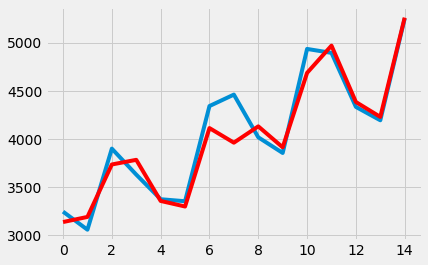

In [ ]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

A line plot is created showing the expected values (blue) compared to the rolling forecast predictions (red). We can see the values show some trend and are in the correct scale


## 4 - Comparing Multiple Models

In [ ]:
df2 = pd.get_dummies(df, columns = ['Quarter'])
df2.columns = ['Sales','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q3','Q3','Q3','Q3','Q3','Q3','Q3','Q3','Q3','Q3','Q4','Q4','Q4','Q4','Q4','Q4','Q4','Q4','Q4','Q4']
df2.head()


,Sales,Q1,Q1,Q1,Q1,Q1,Q1,Q1,Q1,Q1,...,Q4,Q4,Q4,Q4,Q4,Q4,Q4,Q4,Q4,Q4
0,1734.827000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2244.960999,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2533.804993,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2154.962997,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1547.818996,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
t= np.arange(1,43)

In [ ]:
df2['t'] = t
df2['t_sq'] = df2['t']*df2['t']
log_Sales=np.log(df2['Sales'])
df2['log_Sales']=log_Sales

In [ ]:
df2.head()

,Sales,Q1,Q1,Q1,Q1,Q1,Q1,Q1,Q1,Q1,...,Q4,Q4,Q4,Q4,Q4,Q4,Q4,t,t_sq,log_Sales
0,1734.827000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,7.458663
1,2244.960999,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,4,7.716443
2,2533.804993,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,9,7.837477
3,2154.962997,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,16,7.675529
4,1547.818996,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,25,7.344602


In [ ]:
train1, test1 = np.split(df2, [int(.67 *len(df2))])
linear= smf.ols('Sales ~ t',data=train1).fit()
predlin=pd.Series(linear.predict(pd.DataFrame(test1['t'])))
rmselin=np.sqrt((np.mean(np.array(test1['Sales'])-np.array(predlin))**2))
rmselin

580.1224130918635

In [ ]:
quad=smf.ols('Sales~t+t_sq',data=train1).fit()
predquad=pd.Series(quad.predict(pd.DataFrame(test1[['t','t_sq']])))
rmsequad=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(predquad))**2))
rmsequad

783.7297975037552

In [ ]:
expo=smf.ols('log_Sales~t',data=train1).fit()
predexp=pd.Series(expo.predict(pd.DataFrame(test1['t'])))
rmseexpo=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(np.exp(predexp)))**2))
rmseexpo

588.1405104900199

In [ ]:
additive= smf.ols('Sales~ Q1+Q2+Q3+Q4',data=train1).fit()
predadd=pd.Series(additive.predict(pd.DataFrame(test1[['Q1','Q2','Q3','Q4']])))
rmseadd=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(predadd))**2))
rmseadd

1869.7188209186959

In [ ]:
addlinear= smf.ols('Sales~t+Q1+Q2+Q3+Q4',data=train1).fit()
predaddlinear=pd.Series(addlinear.predict(pd.DataFrame(test1[['t','Q1','Q2','Q3','Q4']])))
rmseaddlinear=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(predaddlinear))**2))
rmseaddlinear

596.1526282372297

In [ ]:
mulsea=smf.ols('log_Sales~Q1+Q2+Q3+Q4',data=train1).fit()
predmul= pd.Series(mulsea.predict(pd.DataFrame(test1[['Q1','Q2','Q3','Q4']])))
rmsemul= np.sqrt(np.mean((np.array(test1['Sales'])-np.array(np.exp(predmul)))**2))
rmsemul

2374.9194407954456

In [ ]:
mullin= smf.ols('log_Sales~t+Q1+Q2+Q3+Q4',data=train1).fit()
predmullin= pd.Series(mullin.predict(pd.DataFrame(test1[['t','Q1','Q2','Q3','Q4']])))
rmsemulin=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(np.exp(predmullin)))**2))
rmsemulin

5359.687911933238

In [ ]:
mul_quad= smf.ols('log_Sales~t+t_sq+Q1+Q2+Q3+Q4',data=train1).fit()
pred_mul_quad= pd.Series(mul_quad.predict(test1[['t','t_sq','Q1','Q2','Q3','Q4']]))
rmse_mul_quad=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(np.exp(pred_mul_quad)))**2))
rmse_mul_quad


3630.561946734775

In [ ]:
addquad=smf.ols('Sales~t+t_sq+Q1+Q2+Q3+Q4',data=train1).fit()
predaddquad=pd.Series(addquad.predict(pd.DataFrame(test1[['t','t_sq','Q1','Q2','Q3','Q4']])))
rmseaddquad=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(predaddquad))**2))
rmseaddquad

412.11444360537337

5 - Conclusion

In [ ]:
output = {'Model':pd.Series(['rmse_mul_quad','rmseadd','rmseaddlinear','rmseaddquad','rmseexpo','rmselin','rmsemul','rmsemulin','rmsequad']),
          'Values':pd.Series([rmse_mul_quad,rmseadd,rmseaddlinear,rmseaddquad,rmseexpo,rmselin,rmsemul,rmsemulin,rmsequad])}
rmse=pd.DataFrame(output)

In [ ]:
print(rmse)

           Model       Values
0  rmse_mul_quad  3630.561947
1        rmseadd  1869.718821
2  rmseaddlinear   596.152628
3    rmseaddquad   412.114444
4       rmseexpo   588.140510
5        rmselin   580.122413
6        rmsemul  2374.919441
7      rmsemulin  5359.687912
8       rmsequad   783.729798


## Additive seasonality with quadratic trend has the best RMSE value

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.tsa.statespace as tm_models
from datetime import datetime,time
import warnings
import itertools
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

## 1 - Business Problem

__Forecast the airlines data set. Prepare a document for each model explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting___

## 2 - Data collection and description

In [ ]:
df = pd.read_excel("/content/Airlines+Data.xlsx")
df1 = df.copy()
df1.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [ ]:
df1.isnull().sum()

Month         0
Passengers    0
dtype: int64

In [ ]:
df1.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [ ]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,96.0,213.708333,71.918216,104.0,156.0,200.0,264.75,413.0


In [ ]:
df1 = df1.set_index('Month')

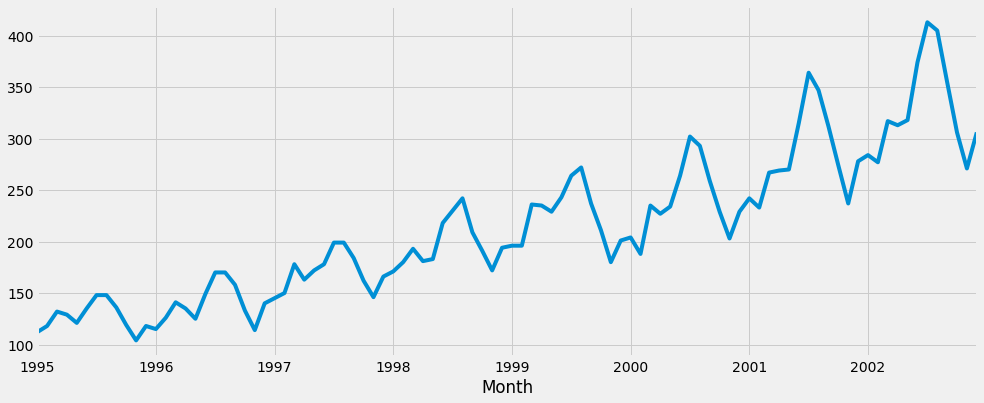

In [ ]:
df1['Passengers'].plot(figsize=(15, 6))
plt.show()

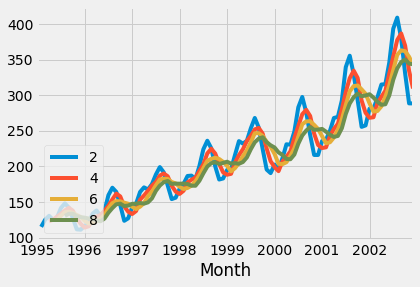

In [ ]:
for i in range(2,10,2):
    df1['Passengers'].rolling(i).mean().plot(label=str(i))
plt.legend(loc=3)

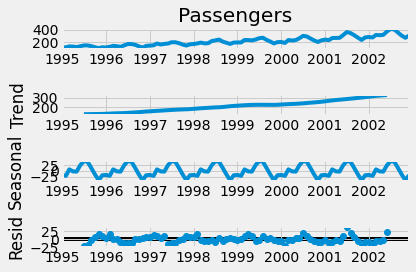

In [ ]:
ts_add = seasonal_decompose(df1['Passengers'],model="additive")
fig = ts_add.plot()
plt.show()

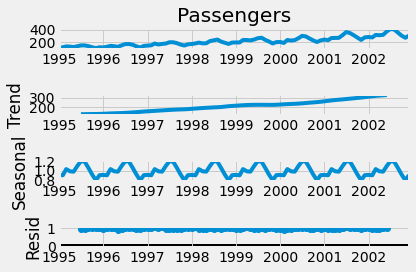

In [ ]:
ts_mul = seasonal_decompose(df1.Passengers,model="multiplicative")
fig = ts_mul.plot()
plt.show()

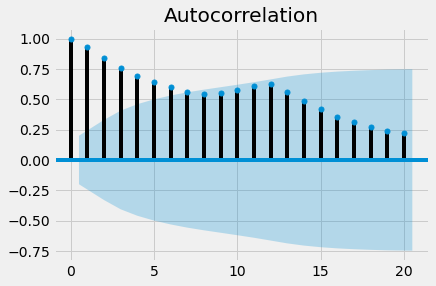

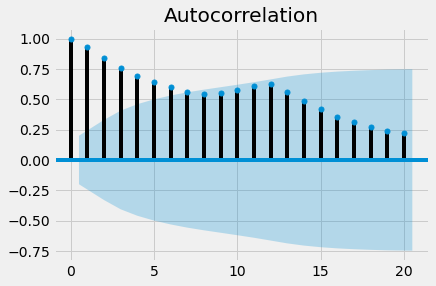

In [ ]:
tsa_plots.plot_acf(df1['Passengers'])

## 3 - Building Time series forecasting with ARIMA

In [ ]:
X = df1['Passengers'].values
size = int(len(X) * 0.66)

In [ ]:
train, test = X[0:size], X[size:len(X)]
model = ARIMA(train, order=(5,1,0))

In [ ]:
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   62
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -262.909
Method:                       css-mle   S.D. of innovations             16.748
Date:                Thu, 10 Nov 2022   AIC                            539.817
Time:                        05:20:05   BIC                            554.707
Sample:                             1   HQIC                           545.663
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7497      1.477      1.185      0.236      -1.145       4.644
ar.L1.D.y      0.0905      0.134      0.677      0.498      -0.171       0.352
ar.L2.D.y     -0.2096      0.135     -1.549      0.1

This summarizes the coefficient values used as well as the skill of the fit on the on the in-sample observations

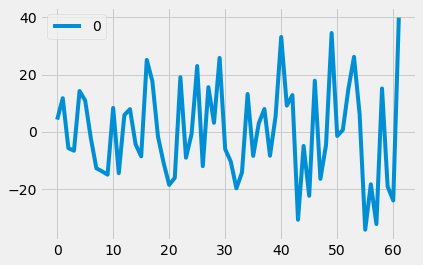

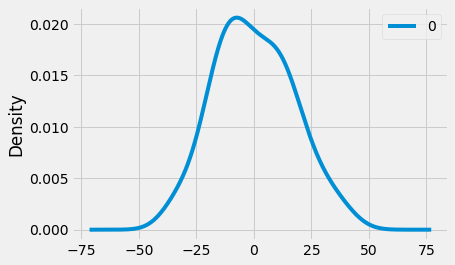

               0
count  62.000000
mean    0.057351
std    16.895802
min   -34.303300
25%   -12.610654
50%    -1.589480
75%    12.565603
max    39.955354


In [ ]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())


The plot of the residual errors suggests that there may still be some trend information not captured by the model
The results show that there is no a bias in the prediction (a zero mean in the residuals)

## 3.1 - Rolling Forecast ARIMA Model

In [ ]:
history = [x for x in train]
predictions = list()

In [ ]:
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=239.755201, expected=227.000000
predicted=220.737320, expected=234.000000
predicted=237.815016, expected=264.000000
predicted=252.750595, expected=302.000000
predicted=306.715968, expected=293.000000
predicted=285.374658, expected=259.000000
predicted=250.264002, expected=229.000000
predicted=227.093128, expected=203.000000
predicted=211.011438, expected=229.000000
predicted=253.260263, expected=242.000000
predicted=252.490668, expected=233.000000
predicted=234.042130, expected=267.000000
predicted=268.773623, expected=269.000000
predicted=261.782249, expected=270.000000
predicted=271.798044, expected=315.000000
predicted=314.422112, expected=364.000000
predicted=368.637707, expected=347.000000
predicted=334.957876, expected=312.000000
predicted=301.161837, expected=274.000000
predicted=265.936490, expected=237.000000
predicted=244.037204, expected=278.000000
predicted=312.961762, expected=284.000000
predicted=291.748169, expected=277.000000
predicted=284.551896, expected=317

In [ ]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 782.495


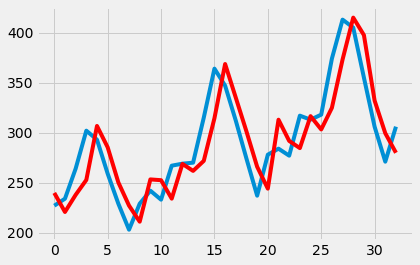

In [ ]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

A line plot is created showing the expected values (blue) compared to the rolling forecast predictions (red). We can see the values show some trend and are in the correct scale


## 4 - Comparing Multiple Models

In [ ]:
df2 = df.copy()
df2 = pd.get_dummies(df2, columns = ['Month'])
df2.head()

,Passengers,Month_1995-01-01 00:00:00,Month_1995-02-01 00:00:00,Month_1995-03-01 00:00:00,Month_1995-04-01 00:00:00,Month_1995-05-01 00:00:00,Month_1995-06-01 00:00:00,Month_1995-07-01 00:00:00,Month_1995-08-01 00:00:00,Month_1995-09-01 00:00:00,...,Month_2002-03-01 00:00:00,Month_2002-04-01 00:00:00,Month_2002-05-01 00:00:00,Month_2002-06-01 00:00:00,Month_2002-07-01 00:00:00,Month_2002-08-01 00:00:00,Month_2002-09-01 00:00:00,Month_2002-10-01 00:00:00,Month_2002-11-01 00:00:00,Month_2002-12-01 00:00:00
0,112,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,118,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,132,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,129,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,121,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df2.shape

(96, 97)

In [ ]:
t= np.arange(1,97)
df2['t'] = t
df2['t_sq'] = df2['t']*df2['t']

In [ ]:
log_Passengers=np.log(df2['Passengers'])
df2['log_Passengers']=log_Passengers

In [ ]:
df2.head()

,Passengers,Month_1995-01-01 00:00:00,Month_1995-02-01 00:00:00,Month_1995-03-01 00:00:00,Month_1995-04-01 00:00:00,Month_1995-05-01 00:00:00,Month_1995-06-01 00:00:00,Month_1995-07-01 00:00:00,Month_1995-08-01 00:00:00,Month_1995-09-01 00:00:00,...,Month_2002-06-01 00:00:00,Month_2002-07-01 00:00:00,Month_2002-08-01 00:00:00,Month_2002-09-01 00:00:00,Month_2002-10-01 00:00:00,Month_2002-11-01 00:00:00,Month_2002-12-01 00:00:00,t,t_sq,log_Passengers
0,112,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,4.718499
1,118,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,4,4.770685
2,132,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,9,4.882802
3,129,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,4,16,4.859812
4,121,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,5,25,4.795791


In [ ]:
train1, test1 = np.split(df2, [int(.67 *len(df2))])

In [ ]:
linear= smf.ols('Passengers ~ t',data=train1).fit()
predlin=pd.Series(linear.predict(pd.DataFrame(test1['t'])))
rmselin=np.sqrt((np.mean(np.array(test1['Passengers'])-np.array(predlin))**2))
rmselin

25.50398351648347

In [ ]:
quad=smf.ols('Passengers~t+t_sq',data=train1).fit()
predquad=pd.Series(quad.predict(pd.DataFrame(test1[['t','t_sq']])))
rmsequad=np.sqrt(np.mean((np.array(test1['Passengers'])-np.array(predquad))**2))
rmsequad

53.189555144151804

In [ ]:
expo=smf.ols('Passengers~t',data=train1).fit()
predexp=pd.Series(expo.predict(pd.DataFrame(test1['t'])))
rmseexpo=np.sqrt(np.mean((np.array(test1['Passengers'])-np.array(np.exp(predexp)))**2))
rmseexpo

1.6030945933279498e+128

## 5 - Conclusion

In [ ]:
output = {'Model':pd.Series(['rmse_mul_quad','rmseadd','rmseaddlinear','rmseaddquad','rmseexpo','rmselin','rmsemul','rmsemulin','rmsequad']),
          'Values':pd.Series([rmse_mul_quad,rmseadd,rmseaddlinear,rmseaddquad,rmseexpo,rmselin,rmsemul,rmsemulin,rmsequad])}
rmse=pd.DataFrame(output)

In [ ]:
print(rmse)

           Model         Values
0  rmse_mul_quad   3.630562e+03
1        rmseadd   1.869719e+03
2  rmseaddlinear   5.961526e+02
3    rmseaddquad   4.121144e+02
4       rmseexpo  1.603095e+128
5        rmselin   2.550398e+01
6        rmsemul   2.374919e+03
7      rmsemulin   5.359688e+03
8       rmsequad   5.318956e+01


Multiplicative seasonality with linear trend has the best RMSE value
 